In [2]:
# first lets import the datset in our colab
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


In [6]:
# lets here make our train and test directory variables
train_dir = r"/kaggle/input/intel-image-classification/seg_train/seg_train"
test_dir = r"/kaggle/input/intel-image-classification/seg_test/seg_test"

In [65]:
import os, shutil, random

def create_small_dataset(src_dir, dest_dir, samples_per_class=400):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    classes = os.listdir(src_dir)
    for cls in classes:
        src_class = os.path.join(src_dir, cls)
        dest_class = os.path.join(dest_dir, cls)
        os.makedirs(dest_class, exist_ok=True)

        imgs = os.listdir(src_class)
        selected = random.sample(imgs, min(samples_per_class, len(imgs)))

        for img in selected:
            shutil.copy(os.path.join(src_class, img),
                        os.path.join(dest_class, img))

create_small_dataset(train_dir, 'small_train', samples_per_class=400)
create_small_dataset(test_dir, 'small_test', samples_per_class=200)


In [66]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam

small_train_dir = 'small_train'
small_test_dir = 'small_test'

train_data = ImageDataGenerator(rescale = 1./255)
train_data = train_data.flow_from_directory(
    small_train_dir,
    target_size=(150,150),
    batch_size = 32,
    class_mode = 'categorical',
    seed = 42)

test_data = ImageDataGenerator(rescale = 1./255)
test_data = test_data.flow_from_directory(
    small_test_dir,
    target_size=(150,150),
    batch_size = 32,
    class_mode = 'categorical',
    seed = 42)


Found 3887 images belonging to 6 classes.
Found 1544 images belonging to 6 classes.


In [67]:
print("train data class names:", train_data.class_indices)

train data class names: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [68]:
print("test data class names:", test_data.class_indices)

test data class names: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [69]:
# Performing some data augmentation like resizing, roatation flip etc etc
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
                                         layers.RandomRotation(0.1),
                                         layers.RandomZoom(0.1),
                                         layers.RandomCrop(140, 140),
                                         layers.Resizing(150, 150),
                                         layers.RandomContrast(0.1)])

In [70]:
# applying learning rate schedule (Cosine Annealing)
lr = 1e-3
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=lr,first_decay_steps=1000)

In [72]:
# Use AdamW optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

# lets create the base cnn model with Regularization
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-4), input_shape=(150,150,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')])

cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining Baseline CNN with Augmentation+ AdamW+ Cosine learning rate(LR)")
cnn_model.fit(train_data, validation_data=test_data, epochs=25)



Training Baseline CNN with Augmentation+ AdamW+ Cosine learning rate(LR)
Epoch 1/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.2711 - loss: 1.6496 - val_accuracy: 0.4301 - val_loss: 1.3180
Epoch 2/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4211 - loss: 1.3508 - val_accuracy: 0.5078 - val_loss: 1.2051
Epoch 3/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4807 - loss: 1.2396 - val_accuracy: 0.5635 - val_loss: 1.1073
Epoch 4/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5318 - loss: 1.1300 - val_accuracy: 0.5810 - val_loss: 1.0469
Epoch 5/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5741 - loss: 1.0836 - val_accuracy: 0.6010 - val_loss: 1.0052
Epoch 6/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5800 - loss: 1.0285 - val_accuracy: 0.6114 - val_loss: 1.0032
Epoch 7/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5994 - loss: 0.9848 - val_accuracy: 0.6146 - val_loss: 0.9790
Epoch 8/25
122/122 ━━━

In [73]:
# importing library for transfer learning restnet50
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False

resnet_model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)
resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining ResNet50")
resnet_model.fit(train_data, validation_data=test_data, epochs=10)



Training ResNet50
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.1559 - loss: 2.0669 - val_accuracy: 0.1665 - val_loss: 1.7943
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.1546 - loss: 1.9364 - val_accuracy: 0.1587 - val_loss: 1.7802
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.1736 - loss: 1.9027 - val_accuracy: 0.2364 - val_loss: 1.7696
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.1839 - loss: 1.8588 - val_accuracy: 0.2610 - val_loss: 1.7614
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.1855 - loss: 1.8327 - val_accuracy: 0.2500 - val_loss: 1.7537
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.1912 - loss: 1.8223 - val_accuracy: 0.2681 - val_loss: 1.7453
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.2063 - loss: 1.8076 - val_accuracy: 0.3057 - val_loss: 1.7372
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accurac

In [74]:
fine_tune_at = len(base_model.layers) * 0.7
for layer in base_model.layers[int(fine_tune_at):]:
    layer.trainable = True

optimizer = Adam(1e-5)
resnet_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
resnet_model.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - accuracy: 0.3050 - loss: 2.1894 - val_accuracy: 0.1723 - val_loss: 1.9549
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.4859 - loss: 1.2338 - val_accuracy: 0.2804 - val_loss: 1.7043
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.5390 - loss: 1.1278 - val_accuracy: 0.5505 - val_loss: 1.1152
Epoch 4/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.5599 - loss: 1.0977 - val_accuracy: 0.5304 - val_loss: 1.1951
Epoch 5/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.6001 - loss: 1.0132 - val_accuracy: 0.6244 - val_loss: 0.9927
Epoch 6/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.6055 - loss: 1.0035 - val_accuracy: 0.5654 - val_loss: 1.1550
Epoch 7/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.6314 - loss: 0.9517 - val_accuracy: 0.6172 - val_loss: 0.9765
Epoch 8/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.6281 - loss: 0

In [76]:
# #lets make cnn + attention model
from tensorflow.keras import layers, models, optimizers

def attention_block(x):
    attn = layers.GlobalAveragePooling2D()(x)
    attn = layers.Dense(x.shape[-1] // 4, activation='relu')(attn)
    attn = layers.Dense(x.shape[-1], activation='sigmoid')(attn)
    attn = layers.Reshape((1, 1, x.shape[-1]))(attn)
    return layers.Multiply()([x, attn])

inputs = layers.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = attention_block(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)

attn_model = models.Model(inputs, outputs)
attn_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

print("\nTraining CNN + Attention (Improved)")
attn_model.fit(train_data, validation_data=test_data, epochs=25)



Training CNN + Attention (Improved)
Epoch 1/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.2990 - loss: 1.6134 - val_accuracy: 0.3718 - val_loss: 1.4497
Epoch 2/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.4152 - loss: 1.3218 - val_accuracy: 0.3595 - val_loss: 1.6541
Epoch 3/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.4552 - loss: 1.2548 - val_accuracy: 0.3562 - val_loss: 2.2076
Epoch 4/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5069 - loss: 1.1745 - val_accuracy: 0.4896 - val_loss: 1.2251
Epoch 5/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.5393 - loss: 1.1204 - val_accuracy: 0.5155 - val_loss: 1.2611
Epoch 6/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.5511 - loss: 1.0921 - val_accuracy: 0.5706 - val_loss: 1.0600
Epoch 7/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5718 - loss: 1.0585 - val_accuracy: 0.5123 - val_loss: 1.2697
Epoch 8/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accu


Evaluating Models...

Baseline CNN Accuracy: 68.39378476142883
ResNet50 Accuracy: 63.860106468200684
Attention CNN Accuracy: 72.60362505912781


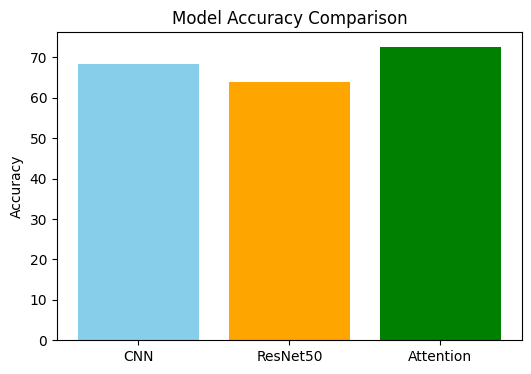

In [82]:
# now lets compare the models
print("\nEvaluating Models...")
cnn_acc = cnn_model.evaluate(test_data, verbose=0)[1]
resnet_acc = resnet_model.evaluate(test_data, verbose=0)[1]
attn_acc = attn_model.evaluate(test_data, verbose=0)[1]

print(f"\nBaseline CNN Accuracy: {cnn_acc*100}")
print(f"ResNet50 Accuracy: {resnet_acc*100}")
print(f"Attention CNN Accuracy: {attn_acc*100}")

plt.figure(figsize=(6,4))
plt.bar(["CNN", "ResNet50", "Attention"], [cnn_acc*100, resnet_acc*100, attn_acc*100], color=['skyblue','orange','green'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


Evaluating Baseline CNN
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
y_true: 1544, y_pred: 1544

Macro F1-score for Baseline CNN: 0.1693

Classification Report for Baseline CNN:
              precision    recall  f1-score   support

   buildings     0.1716    0.2778    0.2121       252
      forest     0.1733    0.1554    0.1639       251
     glacier     0.2070    0.1985    0.2027       267
    mountain     0.1687    0.2137    0.1886       262
         sea     0.1737    0.1107    0.1352       262
      street     0.1474    0.0920    0.1133       250

    accuracy                         0.1749      1544
   macro avg     0.1736    0.1747    0.1693      1544
weighted avg     0.1739    0.1749    0.1696      1544



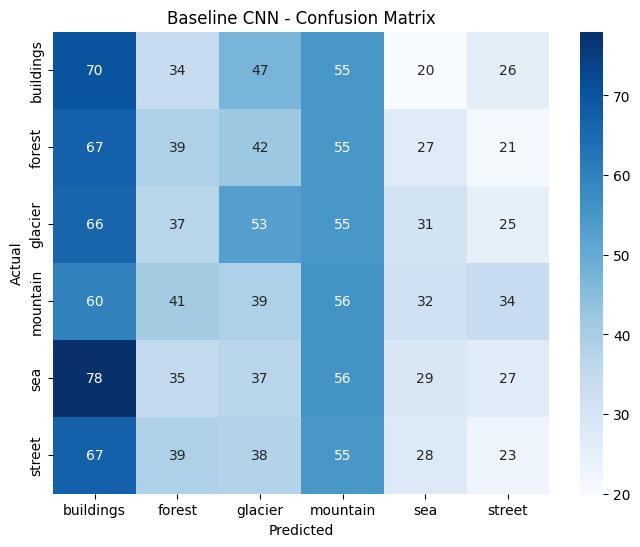


Evaluating ResNet50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step
y_true: 1544, y_pred: 1544

Macro F1-score for ResNet50: 0.1614

Classification Report for ResNet50:
              precision    recall  f1-score   support

   buildings     0.1935    0.2619    0.2226       252
      forest     0.1667    0.1633    0.1650       251
     glacier     0.1551    0.1835    0.1681       267
    mountain     0.1538    0.0458    0.0706       262
         sea     0.1714    0.1832    0.1771       262
      street     0.1555    0.1760    0.1651       250

    accuracy                         0.1684      1544
   macro avg     0.1660    0.1690    0.1614      1544
weighted avg     0.1659    0.1684    0.1610      1544



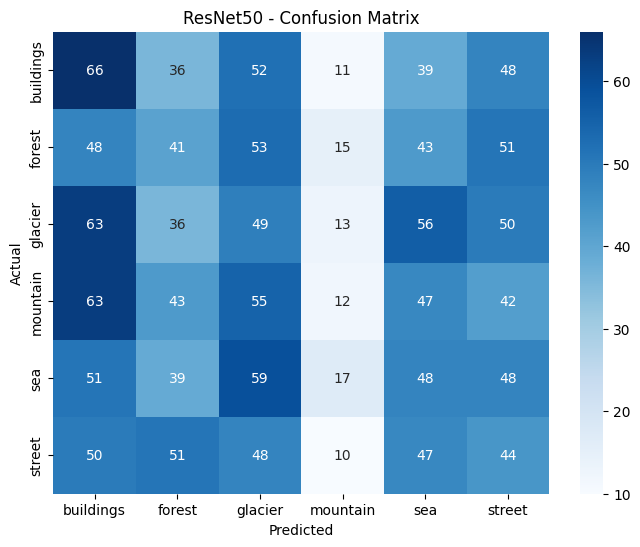


Evaluating Attention CNN
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
y_true: 1544, y_pred: 1544

Macro F1-score for Attention CNN: 0.1704

Classification Report for Attention CNN:
              precision    recall  f1-score   support

   buildings     0.1785    0.2103    0.1931       252
      forest     0.1667    0.1753    0.1709       251
     glacier     0.1750    0.1573    0.1657       267
    mountain     0.2007    0.2252    0.2122       262
         sea     0.1481    0.0916    0.1132       262
      street     0.1568    0.1800    0.1676       250

    accuracy                         0.1729      1544
   macro avg     0.1710    0.1733    0.1704      1544
weighted avg     0.1711    0.1729    0.1703      1544



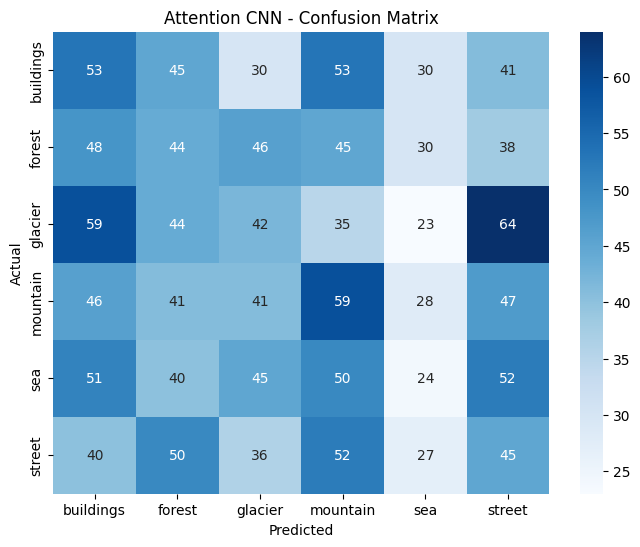

In [77]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_data, model_name):
    print(f"\nEvaluating {model_name}")

    test_data.reset()
    y_pred_probs = model.predict(test_data, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true = test_data.classes
    class_labels = list(test_data.class_indices.keys())

    print(f"y_true: {len(y_true)}, y_pred: {len(y_pred)}")

    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\nMacro F1-score for {model_name}: {macro_f1:.4f}")

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(cnn_model, test_data, "Baseline CNN")
evaluate_model(resnet_model, test_data, "ResNet50")
evaluate_model(attn_model, test_data, "Attention CNN")

predicted class name: buildings (843.4127807617188%)
last conv layer is: conv2d_37


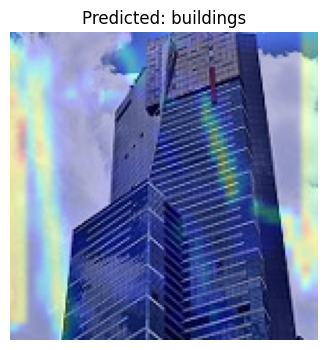

In [80]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display

model = attn_model
model.layers[-1].activation = None

_ = model.predict(np.zeros((1, 150, 150, 3)), verbose=0)

img_size = (150, 150)
img_path = r"/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20057.jpg"

img = keras.utils.load_img(img_path, target_size=img_size)
img_array = keras.utils.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

preds = model.predict(img_array, verbose=0)
pred_class = np.argmax(preds[0])
pred_label = class_labels[pred_class]
confidence = preds[0][pred_class] * 100

print(f"predicted class name: {pred_label} ({confidence}%)")

last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        print("last conv layer is:", last_conv_layer_name)
        break

grad_model = keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    class_idx = tf.argmax(predictions[0])
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    plt.figure(figsize=(6, 4))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label}")
    plt.show()

display_gradcam(img_path, heatmap)
